# Food101- Classification

## Food101 Dataset Samples
![Dataset Samples](food101.png "Dataset Samples")

In [3]:
import torch
from torch import nn,optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

from torchinfo import summary
import seaborn as sns
from torch_lr_finder import LRFinder
import numpy as np
from tqdm import tqdm 
import pandas as pd

from Dataset_food import dataset
from Visualizations import plot_samples,plot_samples2,plot_confusion
from TransferModel import Model
from Main import main,Test_ensemble,Get_predictions

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Dataset and Dataloaders

In [4]:
#Imagnet Weights
Train_set ,Test_set ,Trainloader, Testloader = dataset(data_dir='./food101',batch_size=128,
                                                      Transformation=True,resize=224)
#IMAGENET1K_SWAG_Weights for VIT and REgnet
Train_set ,Test_set ,Trainloader1, Testloader1 = dataset(data_dir='./food101',batch_size=128,
                                                        Transformation=True,resize=384)

### 1.1 Dataset size 

In [5]:
print ("Train_set: "+str(len(Train_set))+",  Test_set: "+str(len(Test_set)))
print(f"Total no. of batches in trainloader : {len(Trainloader)}")
print(f"Total no. of batches in testloader : {len(Testloader)}")

Train_set: 75750,  Test_set: 25250
Total no. of batches in trainloader : 592
Total no. of batches in testloader : 198


### 1.2 Classes number and distribution

In [6]:
classes=Train_set.classes
print("Classes number :",len(classes),"\n")

print("Samples of Data Classes:",classes[:10])


Classes number : 101 

Samples of Data Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
Train_dict={}
for i in range (len(Train_set)):
    Train_dict[i]=Train_set[i][1]

In [16]:
Train_lbls=pd.DataFrame(pd.Series(Train_dict))
ClassesTrain=Train_lbls.value_counts().sort_values()
ClassesTrain

0      750
4      750
5      750
6      750
7      750
      ... 
99     750
78     750
77     750
91     750
100    750
Length: 101, dtype: int64

<AxesSubplot: xlabel='0'>

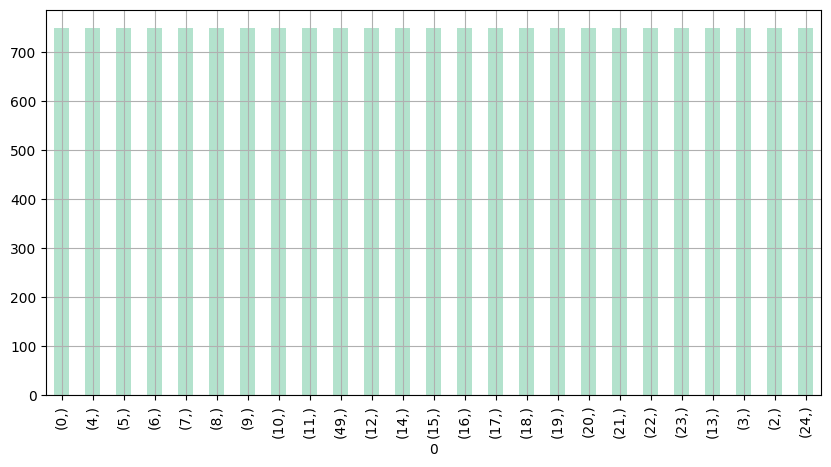

In [17]:
ClassesTrain[:25].plot(kind='bar',figsize=(10,5),colormap="Pastel2",grid=True)

### 1.3 Plot Samples of Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


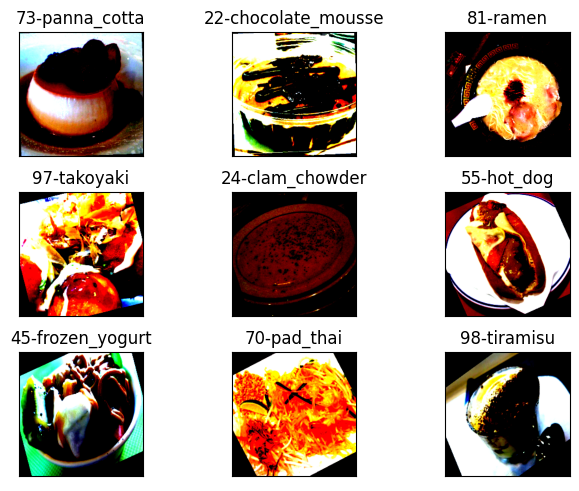

In [20]:
#print(Train_set[0][0].shape)
plot_samples(Train_set)

## 3. Model Parameters
Model Archictecture <br>
Loss Function <br>
Obtimizer<br>

### 3.1 Transfer Learning for the model
Top accuracies and Latest models at torchVision

In [4]:
models_arch=["vit_b_16","swin_b","efficientnet_v2_m","regnet_y_16gf"]
num_classes=101

In [5]:
# Create Instances of Our Models
models={}
for model in models_arch:
    if model=="regnet_y_16gf" or model=="vit_b_16":
        models[model]=Model(model,num_classes=num_classes,weights="IMAGENET1K_SWAG_E2E_V1",device=device)
    else:
        # Create Instances of Our Models
        models[model]=Model(model,num_classes=num_classes,weights="IMAGENET1K_V1",device=device)
    
keys=list(models.keys())
#keys

Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main


### 3.2 Loss Function and Optimizer

In [6]:
loss_fn = nn.CrossEntropyLoss()

def Get_optimizer(model,opt="SGD",lr=3e-3):
    if opt=="SGD":
        return  optim.SGD(model.parameters(), lr=lr)
    elif opt=="Adam":
        return optim.Adam(model.parameters(), lr=lr)
    elif opt=="RMSprop":
        return optim.RMSprop(model.parameters(), lr=lr)

### 3.3 LR

In [9]:
def Get_LR(Trainloader,model,optimizer,loss_fn,device="cuda"):
    lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
    lr_finder.range_test(Trainloader, end_lr=100, num_iter=100)
    lr_finder.plot() 
    lr_finder.reset()

## 4 Training and Testing

#### 4.1 VISION TRANSFORMER (VIT_b16)

Fist, Find the `Lr` of the model and optimizer

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-04


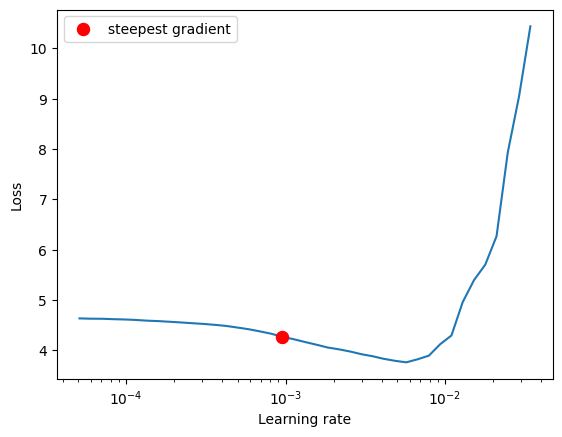

In [8]:
lr=1e-5
#model1=Model(keys[0],num_classes=num_classes,device=device)
model1=models[keys[0]]
optimizer1=Get_optimizer(model1,opt="RMSprop",lr=lr)

Get_LR(Trainloader1,model1,optimizer1,loss_fn,device="cuda")

Secondly, Train the model at the selected `lr=1e-2`

#### 4.1.1 VIT with Only IMAGENET Weights

In [26]:
main(model1,Trainloader,Testloader,Testloader,loss_fn,
     optimizer1,lr,name="vit",epochs=20,save_weights=True,scheduler_bol=True)

Ep[Train]1/20: 100%|██| 592/592 [12:45<00:00,  1.29s/it, loss=2.470, acc=0.4301]
Epoch[Test]1/20: 100%|█| 198/198 [05:52<00:00,  1.78s/it, loss=1.771, acc=0.5304
Ep[Train]2/20: 100%|██| 592/592 [12:31<00:00,  1.27s/it, loss=1.820, acc=0.5372]
Epoch[Test]2/20: 100%|█| 198/198 [03:51<00:00,  1.17s/it, loss=1.593, acc=0.5825
Ep[Train]3/20: 100%|██| 592/592 [12:35<00:00,  1.28s/it, loss=1.721, acc=0.5605]
Epoch[Test]3/20: 100%|█| 198/198 [03:56<00:00,  1.20s/it, loss=1.567, acc=0.5906
Ep[Train]4/20: 100%|██| 592/592 [34:43<00:00,  3.52s/it, loss=1.375, acc=0.6407]
Epoch[Test]4/20: 100%|█| 198/198 [05:58<00:00,  1.81s/it, loss=1.232, acc=0.6702
Ep[Train]5/20: 100%|██| 592/592 [29:26<00:00,  2.98s/it, loss=1.285, acc=0.6600]
Epoch[Test]5/20: 100%|█| 198/198 [04:25<00:00,  1.34s/it, loss=1.199, acc=0.6770
Ep[Train]6/20: 100%|██| 592/592 [15:23<00:00,  1.56s/it, loss=1.245, acc=0.6675]
Epoch[Test]6/20: 100%|█| 198/198 [03:50<00:00,  1.16s/it, loss=1.178, acc=0.6864
Ep[Train]7/20: 100%|██| 592/

KeyboardInterrupt: 

#### 4.1.2 VIT with IMAGENET1K_SWAG_Weights 

In [9]:
lr=1e-2
#model1=Model(keys[0],num_classes=num_classes,device=device)
model1=models[keys[0]]
optimizer1=Get_optimizer(model1,opt="RMSprop",lr=lr)

main(model1,Trainloader1,Testloader1,Testloader1,loss_fn,
     optimizer1,lr,name=keys[0],epochs=15,save_weights=True,scheduler_bol=True,sch_step=5)

Ep[Train]1/15: 100%|█| 592/592 [1:35:37<00:00,  9.69s/it, loss=1.958, acc=0.5817
Epoch[Test]1/15: 100%|█| 198/198 [13:35<00:00,  4.12s/it, loss=1.286, acc=0.6947
Ep[Train]2/15: 100%|██| 592/592 [38:11<00:00,  3.87s/it, loss=1.202, acc=0.6967]
Epoch[Test]2/15: 100%|█| 198/198 [09:26<00:00,  2.86s/it, loss=0.969, acc=0.7502
Ep[Train]3/15: 100%|██| 592/592 [30:33<00:00,  3.10s/it, loss=1.134, acc=0.7155]
Epoch[Test]3/15: 100%|█| 198/198 [09:28<00:00,  2.87s/it, loss=0.923, acc=0.7594
Ep[Train]4/15: 100%|██| 592/592 [30:27<00:00,  3.09s/it, loss=1.114, acc=0.7247]
Epoch[Test]4/15: 100%|█| 198/198 [09:26<00:00,  2.86s/it, loss=0.982, acc=0.7645
Ep[Train]5/15: 100%|██| 592/592 [30:27<00:00,  3.09s/it, loss=1.094, acc=0.7297]
Epoch[Test]5/15: 100%|█| 198/198 [09:26<00:00,  2.86s/it, loss=0.937, acc=0.7701
Ep[Train]6/15: 100%|██| 592/592 [30:26<00:00,  3.09s/it, loss=0.809, acc=0.7939]
Epoch[Test]6/15: 100%|█| 198/198 [09:26<00:00,  2.86s/it, loss=0.699, acc=0.8286
Ep[Train]7/15: 100%|██| 592/

## 5.Load Best model  

In [7]:
model1_best=models[keys[0]]
model1_best.load_state_dict(torch.load(f"Saved_weights/best_weights_{keys[0]}.pt"))

<All keys matched successfully>

In [11]:
lr=1e-2
optimizer=Get_optimizer(model1_best,opt="RMSprop",lr=lr)
main(model1_best,Trainloader1,Testloader1,Testloader1,loss_fn,optimizer,lr,Test=True)

Epoch[Test]1/1: 100%|█| 198/198 [09:24<00:00,  2.85s/it, loss=0.659, acc=0.8357]


## 6. Visualize Output 
Create a small subset of testset for Visualizing Results

In [8]:
Testset_small,Testloader_small=dataset(data_dir='./food101',batch_size=128,
                                       Transformation=True,resize=384,smallset=True)

In [9]:
labels,preds=Get_predictions(model1_best,Testloader_small,device="cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


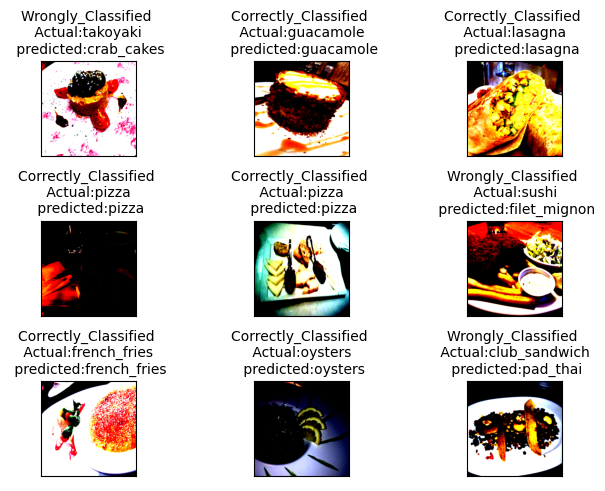

In [10]:
plot_samples2(Testset_small,preds=preds)